# [DRAFT] Combining New Fmask with S2 ARD and Applying WOfS <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Prerequisites:** Users of this notebook should complete
    * [DEA Water Observations](DEA_Water_Observations.ipynb) for context of WOfS
    * [Applying WOfS to S2](Applying_WOfS_to_S2.ipynb) to see how WOfS can be applied to Sentinel 2 ARD 

## Background
Upon investigation, some errors from the `Fmask` layer have been propagated through to the Water Observations (Sentinel 2, Provisional) output. Some new `Fmask` layers have been generated for this notebook using different parameters `Fmask_Outputs`. We cannot conclude they are improvements until the layers have been sent through WOfS to evaluate the final output.

To send the new Fmask layers through WOfS, we can combine them with the S2 ARD bands required for WOfS. In this notebook, we will load an Fmask geotiff and combine it with a S2 ARD granule as an `xarray.Dataset` for further analysis. 

For more information on the `xarray` and `rioxarray` functions used:

* [rioxarray.open_rasterio](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio)
* [xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
* [xarray.open_mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html)

## Description
This notebook shows how to open raster data from file using `xarray`'s built-in fuctions for handling GeoTIFF and NetCDF files, and merging the raster data with S2 ARD. It then demonstrates how WOfS can be applied to the new dataset to visualise the differences from changing the fmask parameters.

1. Opening single GEOTIFF raster files (the new fmask output)
    * Convert to xarray.Dataset
2. Find corresponding S2 ARD from datacube.
    * Convert to xarray.Dataset
3. Combine the two arrays to get one full dataset. 
    * Ensure they have the same spatial reference
4. Apply WOfS and evaluate the output
***

## Getting started
 To run this example, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [32]:
# Let python know to plot figures after the cells they are called in
%matplotlib inline

# Import general packages and tools
import numpy as np
import xarray as xr
import rioxarray
import datacube
import rasterio.crs
import rasterio
from datetime import datetime, timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS 
from datacube.utils.cog import write_cog
import ee

from dea_tools.plotting import display_map, rgb

# Import DEA tools
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import paths_to_datetimeindex, load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb, plot_wo
from dea_tools.temporal import time_buffer
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster

# local copy of WOfS - input bands have been adjusted.
sys.path.insert(1, "../S2_WO_Quality_Testing/wofs-1.6.5/")
from wofs.wofls import woffles_ard

## Opening a single raster file

### Define file paths
In the code below we define the locations of the GeoTIFF files that we will open. These were created when testing fmask parameters on S2 imagery. The fmask output is a classified layer with 6 classes: `null`, `clear`, `cloud`, `shadow`, `snow`, and `water`. To open a different tile, edit the geotiff name to the corresponding file. 

|Tile ID| General Area | Date | Issue Explored | Filename | Thumbnail |
| --- | --- | --- | --- | --- | --- |
| 55HBA | Murrabit | 2023/05/15 | Control Group | filename |[Thumbnail 55HBA](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/55/HBA/2023/05/15/20230515T014126/ga_s2bm_nbart_3-2-1_55HBA_2023-05-15_final_thumbnail.jpg) |
| 50HNH | Ryansbrook | 2023/03/19 | Control Group | filename |[Thumbnail 50HNH](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/50/HNH/2023/03/19/20230319T042722/ga_s2bm_nbart_3-2-1_50HNH_2023-03-19_final_thumbnail.jpg) |
| 50HLK | Perth | 2023/04/26 | Severe Underestimate | 50HLK_20230426_newfmask.tif |[Thumbnail 50HLK](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/50/HLK/2023/04/26/20230426T052534/ga_s2am_nbart_3-2-1_50HLK_2023-04-26_final_thumbnail.jpg) |
| 54HVH | Renmark | 2023/05/06 | Severe Underestimate | 54HVH_newfmask.tif |[Thumbnail 54HVH](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/54/HVH/2023/05/06/20230506T032513/ga_s2am_nbart_3-2-1_54HVH_2023-05-06_final_thumbnail.jpg) |
| 54HTG | Adelaide | 2023/04/24 | False Positive Buildings | 54HTG_20230424_CDI.tif |[Thumbnail 54HTG](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/54/HTG/2023/04/24/20230424T021111/ga_s2bm_nbar_3-2-1_54HTG_2023-04-24_final_thumbnail.jpg) |
| 56JNQ | Gold Coast | 2023/04/06 | False Positive Buildings| filename |[Thumbnail 56JNQ](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/56/JNQ/2023/04/05/20230406T004909/ga_s2bm_nbart_3-2-1_56JNQ_2023-04-05_final_thumbnail.jpg) |
| 50HMG | Lake Muir | 2023/09/05 | Cloud over Lake | filename |[Thumbnail 50HMG](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/50/HMG/2023/09/05/20230905T052006/ga_s2bm_nbar_3-2-1_50HMG_2023-09-05_final_thumbnail.jpg) |
| 53JQJ | Lake Eyre | 2023/07/06 | Cloud over Salt Lake | filename |[Thumbnail 53JQJ](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/53/JQJ/2023/07/06/20230706T022413/ga_s2bm_nbart_3-2-1_53JQJ_2023-07-06_final_thumbnail.jpg) |
| 56HLJ | Cessnock | 2023/07/28 | Altocumulus Clouds | filename |[Thumbnail 56HLJ](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/56/HLJ/2023/07/28/20230728T005606/ga_s2bm_nbar_3-2-1_56HLJ_2023-07-28_final_thumbnail.jpg) |
| 51JWL | Yeo Lake Nature Reserve | 2023/07/06 | Cirrus Clouds | filename |[Thumbnail 51JWL](https://data.dea.ga.gov.au/baseline/ga_s2am_ard_3/51/JWL/2023/07/06/20230706T040332/ga_s2am_nbar_3-2-1_51JWL_2023-07-06_final_thumbnail.jpg) |
| 53HME | Pureba Conservation Park | 2023/07/06 | Cumulus Clouds | filename |[Thumbnail 53HME](https://data.dea.ga.gov.au/baseline/ga_s2bm_ard_3/53/HME/2023/07/06/20230706T022413/ga_s2bm_nbar_3-2-1_53HME_2023-07-06_final_thumbnail.jpg) |

*note clay pans are relatively low priority as they can be masked with a vector file.

In [2]:
sys.path.insert(1, '../dev/dea-notebooks/')
geotiff_path = '../S2_WO_Quality_Testing/Fmask_Outputs/50HMG_newparam.tif'

### Open the new Fmask layer

To open a geotiff we use `rioxarray.open_rasterio()` function which is built around the `rasterio` Python package.
When dealing with extremely large rasters, this function can be used to load data as a Dask array by providing a `chunks` parameter (e.g. `chunks={'x': 1000, 'y': 1000}`). This can be useful to reduce memory usage by only loading the specific portion of the raster you are interested in.

In [3]:
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio(geotiff_path)
# geotiff_da = geotiff_da.rio.write_nodata(0, encoded = True, inplace = True) #is this line necessary - test with and without it.
# Covert our xarray.DataArray into a xarray.Dataset
geotiff_dss = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_dss.rename({1: 'fmask'})

# check array
geotiff_ds
geotiff_ds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes: (12/18)
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 50S",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    ...                                ...
    longitude_of_central_meridian:     117.0
    false_easting:                     500000.0
    false_northing:                    10000000.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 50S",GEOGCS[...
    GeoTransform:                      398740.0 20.0 0.0 6200560.0 0.0 -20.0

This new fmask layer is already georeferenced, so it will be easier to find the corresponding S2 ARD. 

We can check what the new fmask layer looks like by plotting it. 

|Fmask Value | Class |
| --- | --- |
| 0 | Null |
| 1 | Clear |
| 2 | Cloud |
| 3 | Shadow |
| 4 | Snow |
| 5 | Water |

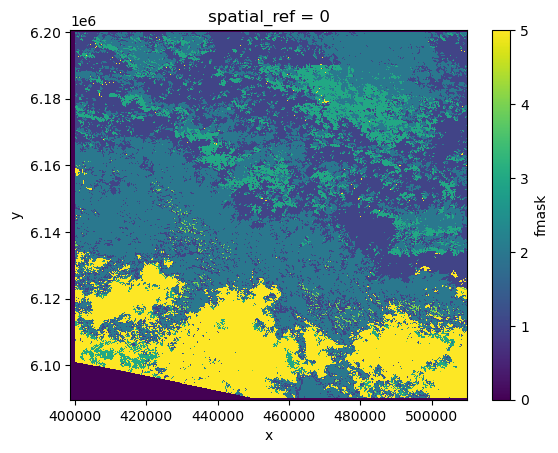

In [4]:
geotiff_ds.fmask.plot()

While we know what the fmask numbers represent from the metadata, this isn't explicitly defined in the dataset yet. To set this, we can assign attributes to the fmask layer.

In [5]:
# Check the format of xarray
geotiff_ds.info

# Assign attributes to the fmask layer
geotiff_ds['fmask'].attrs = {'nodata': 0,
                             'bits': [0, 1, 2, 3, 4, 5, 6, 7], 
                             'values': {'0': 'nodata', '1': 'valid', '2': 'cloud', '3': 'shadow', '4': 'snow', '5': 'water'}, 
                             'description': 'Fmask'}

In [6]:
# Check whether the attributes have been assigned correctly
geotiff_ds['fmask']

<xarray.DataArray 'fmask' (y: 5545, x: 5557)>
[30813565 values with dtype=uint8]
Coordinates:
  * x            (x) float64 3.988e+05 3.988e+05 ... 5.098e+05 5.099e+05
  * y            (y) float64 6.201e+06 6.201e+06 6.201e+06 ... 6.09e+06 6.09e+06
    spatial_ref  int64 0
Attributes:
    nodata:       0
    bits:         [0, 1, 2, 3, 4, 5, 6, 7]
    values:       {'0': 'nodata', '1': 'valid', '2': 'cloud', '3': 'shadow', ...
    description:  Fmask

## Load Corresponding Sentinel 2 ARD
To see how the new fmask layer influences the WOfS output, we'll need to plot both the default and new outputs to visualise the differences. To do so, we will need to load in 2 sets of S2 ARD that span the same study area defined by the new fmask layer. One set will have all the default S2 bands needed for WOfS `dsdefault`. The other will have the same bands, except the default fmask layer is not included so it can be replaced with the new fmask layer later `dsnew`.

Bands required in this notebook are `nbart_coastal_aerosol`, `nbart_blue`, `nbart_green`, `nbart_red`, `nbart_nir_1`, `nbart_nir_2`, `nbart_swir_2`, and `nbart_swir_3`. `dsdefault` includes `oa_fmask` for comparison.

When loading in data, it is convenient to separate fixed parameters that will not need updating from the dynamic variables that can be changed for testing. 

In [7]:
# Connect to the Datacube
dc = datacube.Datacube(app='Cloud_Masking_fromfmask')

# Set up dask
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/aman.chopra@ga.gov.au/proxy/8787/status,
Dashboard: /user/aman.chopra@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34181,Workers: 1
Dashboard: /user/aman.chopra@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:41557,Total threads: 15
Dashboard: /user/aman.chopra@ga.gov.au/proxy/36781/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:42501,


In [8]:
# Fixed parameters
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
# don't need red edge, not concerned about vegetation.
measurements = ["nbart_blue", "nbart_green", "nbart_red", "nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3","oa_s2cloudless_mask", "oa_solar_azimuth"]
measurementsdefault = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]
resolution = (-10, 10) #testing -20,20, original -10,10 (12/12/23)
output_crs = "EPSG:3577"
align = (5, 5) # check this
maturity = "final" 


In [9]:
# Dynamic Parameters
# Time of interest can be taken from table of tiles
time_of_interest = '2023-09-05'
# Time Buffer. Searches for data within the time buffer from the time of interest. 
# For testing purposes, this is 1 day because we know what date to inspect.
time_buff = '1 days'

In [10]:
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements1, resolution, align):
    # Extract the feature's geometry as a datacube geometry object
    # geom = Geometry(geom=row.geometry, crs=gdf.crs)
         
    # dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577"    # if no data is found to prevent an error    
    # native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             'measurements': measurementsdefault,
            # 'resolution': resolution,
            # 'output_crs': native_crs,
            # 'align': align,
             'like': geotiff_ds.geobox,
             'group_by': 'solar_day',
             'dask_chunks':{}
             }                                         
                                              
    return query                                         

In [11]:
query = loadquery(products, time_of_interest, time_buff, measurementsdefault, resolution, align)

# Load Sentinel 2
dsdefault = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
        dataset_maturity="final",
        **query)

# Copy the oa_fmask variable and name it fmask
dsdefault['fmask'] = dsdefault['oa_fmask']

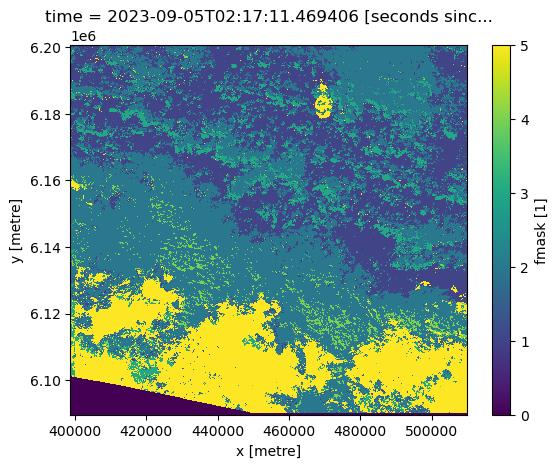

In [12]:
# compare default S2 Fmask layer
dsdefault.fmask.plot()

In [13]:
# inspect the structure of the original S2 dataset.
dsdefault.isel(time=0)

<xarray.Dataset>
Dimensions:                (y: 5545, x: 5557)
Coordinates:
    time                   datetime64[ns] 2023-09-05T02:17:11.469406
  * y                      (y) float64 6.201e+06 6.201e+06 ... 6.09e+06 6.09e+06
  * x                      (x) float64 3.988e+05 3.988e+05 ... 5.099e+05
    spatial_ref            int32 32750
Data variables:
    nbart_coastal_aerosol  (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_blue             (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_green            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_red              (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_nir_1            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_nir_2            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_swir_2           (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_swir_3           (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    oa_fmask               (y, x) uint8 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    fmask                  (y, x) uint8 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

### Load the Same S2 Data for Merging
This time, we'll leave out the default `fmask` layer that is part of the S2 ARD so we can replace it with one of the new fmask layers we generated for this notebook.

In [14]:
# load ARD without fmask, merge the new fmask into the array
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements, resolution, align):
    # Extract the feature's geometry as a datacube geometry object
    # geom = Geometry(geom=row.geometry, crs=gdf.crs)
         
    # dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577"    # if no data is found to prevent an error    
    # native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             'measurements': measurements,
            # 'resolution': resolution,
            # 'output_crs': native_crs,
            # 'align': align,
             'like': geotiff_ds.geobox,
             'group_by': 'solar_day',
             'dask_chunks':{}
             }                                            
                                              
    return query             

In [15]:
query = loadquery(products, time_of_interest, time_buff, measurements, resolution, align)

# Load Sentinel 2
dsnew = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
        dataset_maturity="final",
        **query)

In [16]:
# Check dataset
dsnew

<xarray.Dataset>
Dimensions:                (time: 1, y: 5545, x: 5557)
Coordinates:
  * time                   (time) datetime64[ns] 2023-09-05T02:17:11.469406
  * y                      (y) float64 6.201e+06 6.201e+06 ... 6.09e+06 6.09e+06
  * x                      (x) float64 3.988e+05 3.988e+05 ... 5.099e+05
    spatial_ref            int32 32750
Data variables:
    nbart_blue             (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_green            (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_red              (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_coastal_aerosol  (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_nir_1            (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_nir_2            (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_swir_2           (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    nbart_swir_3           (time, y, x) int16 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    oa_s2cloudless_mask    (time, y, x) uint8 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
    oa_solar_azimuth       (time, y, x) float32 dask.array<chunksize=(1, 5545, 5557), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

## Combine into Single xarray.Dataset
It is difficult to perform raster analyses across separate datasets, so it can be usefull to load multiple files into a single `xarray.Dataset`.
This also allows us to analyse data in a format that is directly compatible with data directly loaded from the Datacube.

#### This current method is for testing 1 timestep at a time to reduce dimension complications. 

To reduce the dataset to one timestep, you can:
   * drop the time dimension entirely -> ard.drop("time")
   * take the first timestep ds.isel(time=0)
   * or set time dimension for fmask and make it equal to ARD time, so the arrays will only merge if the timesteps match.


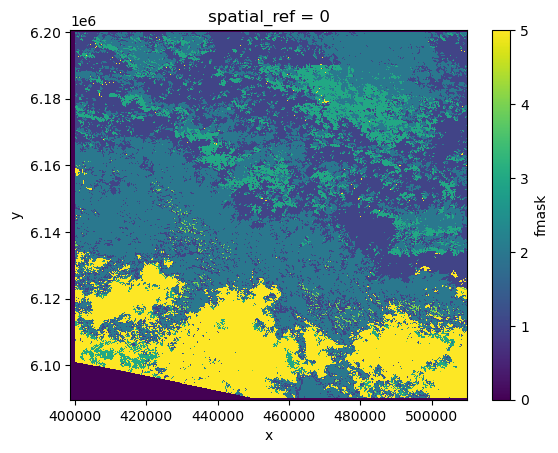

In [17]:
# check this is the new fmask we want to merge
geotiff_ds.fmask.plot()

In [18]:
# since the new fmask layer only exists in one timestep, we'll reduce the ARD to one timestep as well so they can be merged.
ard = dsnew.isel(time=0)
# geotiff_ds = geotiff_dss.where(geotiff_dss['fmask'] != 0.)
datasets=[ard,geotiff_ds]

In [19]:
# Combine the two datasets into one xarray.Dataset
combined = xr.merge(datasets, join='outer', compat = 'override')

# Check dataset
combined

<xarray.Dataset>
Dimensions:                (y: 5545, x: 5557)
Coordinates:
    time                   datetime64[ns] 2023-09-05T02:17:11.469406
  * y                      (y) float64 6.201e+06 6.201e+06 ... 6.09e+06 6.09e+06
  * x                      (x) float64 3.988e+05 3.988e+05 ... 5.099e+05
    spatial_ref            int32 32750
Data variables:
    nbart_blue             (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_green            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_red              (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_coastal_aerosol  (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_nir_1            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_nir_2            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_swir_2           (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_swir_3           (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    oa_s2cloudless_mask    (y, x) uint8 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    oa_solar_azimuth       (y, x) float32 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    fmask                  (y, x) uint8 ...
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

To verify the data was loaded correctly, we can plot it using `xarray`:

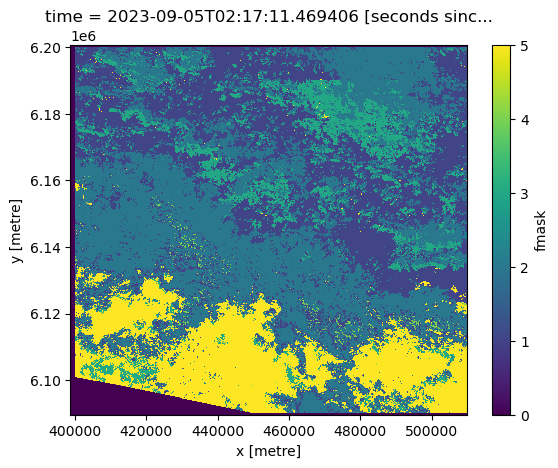

In [20]:
# plot the new fmask layer to see if it exists in the combined dataset.
combined.fmask.plot()

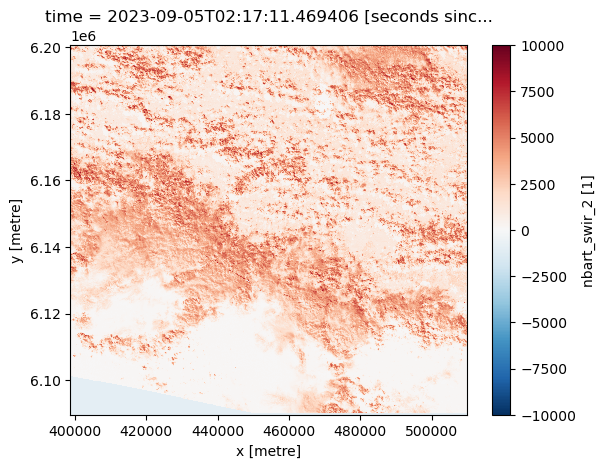

In [21]:
# plot the red band to see if it exists in the combined dataset.
combined.nbart_swir_2.plot()

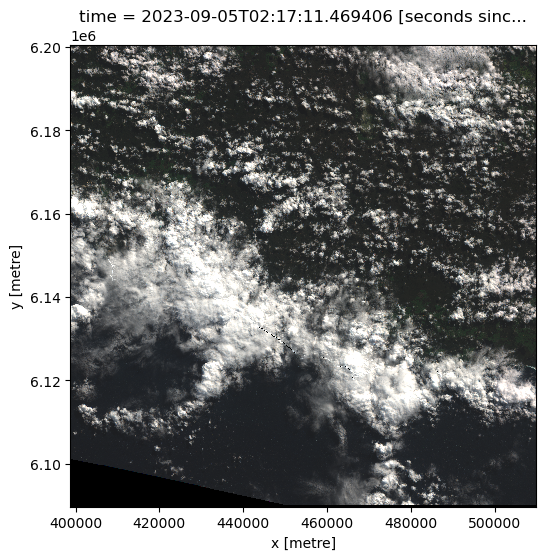

In [22]:
rgb(combined, bands=["nbart_red", "nbart_green", "nbart_blue"])

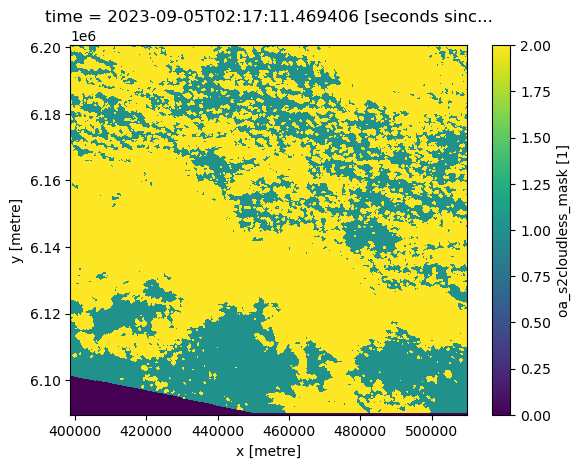

In [23]:
combined.oa_s2cloudless_mask.plot()

In [39]:
!ls ~/.config/

dask  matplotlib


In [38]:
# Trigger the authentication flow.
ee.Authenticate()

# # Initialize the library.
# ee.Initialize(project='neural-tome-382709')
# gee_image = ee.Image((combined.oa_s2cloudless_mask.values == 2).tolist())

Enter verification code:  4/1AfJohXlnVKQk2SjKX1ETV075X6SlMpMrxPvvQZ0YmafqcDfc9Ww-_G2wMXE


URLError: <urlopen error [Errno 101] Network is unreachable>

In [24]:
shadow_azimuth = combined.oa_solar_azimuth

In [25]:
n = shadow_azimuth.to_numpy()

In [26]:
90 - n

array([[50.21805 , 50.21829 , 50.21853 , ..., 51.526134, 51.52638 ,
        51.526623],
       [50.218143, 50.218384, 50.218624, ..., 51.526234, 51.526478,
        51.526722],
       [50.21824 , 50.21848 , 50.218716, ..., 51.52633 , 51.526573,
        51.526817],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

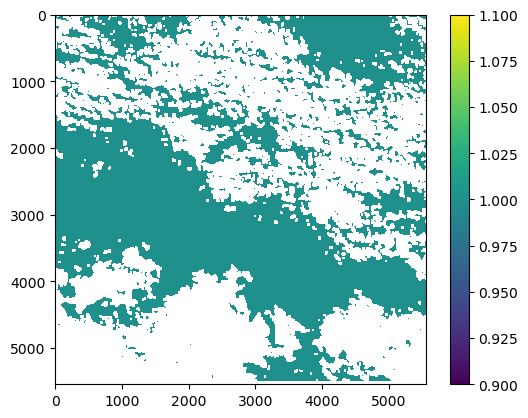

In [57]:
import numpy.ma as ma
s2m = ma.MaskedArray(combined.oa_s2cloudless_mask == 2, mask = (combined.oa_s2cloudless_mask != 2))
plt.imshow(s2m)
plt.colorbar()
plt.show()

In [58]:
from scipy import ndimage
edt = ndimage.distance_transform_edt(s2m)

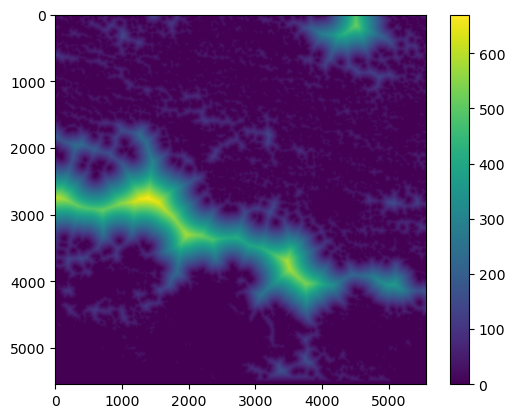

In [61]:
plt.imshow(edt)
plt.colorbar()
plt.show()

In [48]:
proj = np.where(combined.oa_s2cloudless_mask == 2).directionalDistanceTransform(90-n, 10)

AttributeError: 'tuple' object has no attribute 'directionalDistanceTransform'

In [38]:
import ee

In [39]:
# Determine the direction to project cloud shadow from clouds (assumes UTM projection).
shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

# Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
    .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
    .select('distance')
    .mask()
    .rename('cloud_transform'))

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [24]:
combined

<xarray.Dataset>
Dimensions:                (y: 5545, x: 5557)
Coordinates:
    time                   datetime64[ns] 2023-09-05T02:17:11.469406
  * y                      (y) float64 6.201e+06 6.201e+06 ... 6.09e+06 6.09e+06
  * x                      (x) float64 3.988e+05 3.988e+05 ... 5.099e+05
    spatial_ref            int32 32750
Data variables:
    nbart_blue             (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_green            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_red              (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_coastal_aerosol  (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_nir_1            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_nir_2            (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_swir_2           (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    nbart_swir_3           (y, x) int16 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    oa_s2cloudless_mask    (y, x) uint8 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    oa_solar_azimuth       (y, x) float32 dask.array<chunksize=(5545, 5557), meta=np.ndarray>
    fmask                  (y, x) uint8 ...
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

In [25]:
combined_s2 = combined.copy()

In [26]:
combined_s2.fmask.attrs

{'nodata': 0,
 'bits': [0, 1, 2, 3, 4, 5, 6, 7],
 'values': {'0': 'nodata',
  '1': 'valid',
  '2': 'cloud',
  '3': 'shadow',
  '4': 'snow',
  '5': 'water'},
 'description': 'Fmask'}

In [27]:
combined_s2_dropped = combined_s2.drop_vars(names="fmask")

In [28]:
combined_s2_proper = combined_s2_dropped.rename_vars(name_dict = {"oa_s2cloudless_mask":"fmask"})

## Apply WOfS
Now our two datasets are ready. We have one set of S2 ARD with the default Fmask layer `dsdefault`, and another with the new fmask layer swapped in `combined`.

/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../S2_WO_Quality_Testing/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


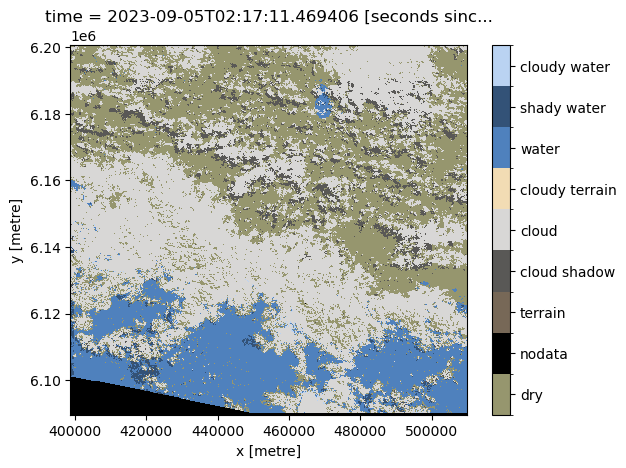

In [29]:
# Apply woffles ard
defaultwofls = woffles_ard(dsdefault.isel(time=0), dsm=None)
# Plot woffles ard output
plot_wo(defaultwofls)

/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../S2_WO_Quality_Testing/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


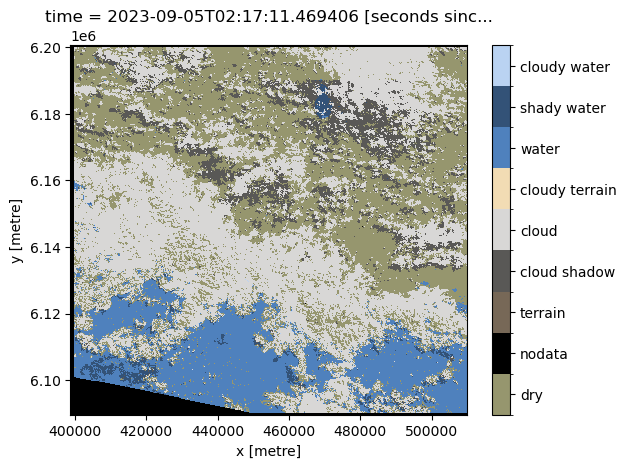

In [30]:
# Apply woffles ard
newwofls = woffles_ard(combined, dsm=None)
# plot woffles ard output
plot_wo(newwofls)

/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../S2_WO_Quality_Testing/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


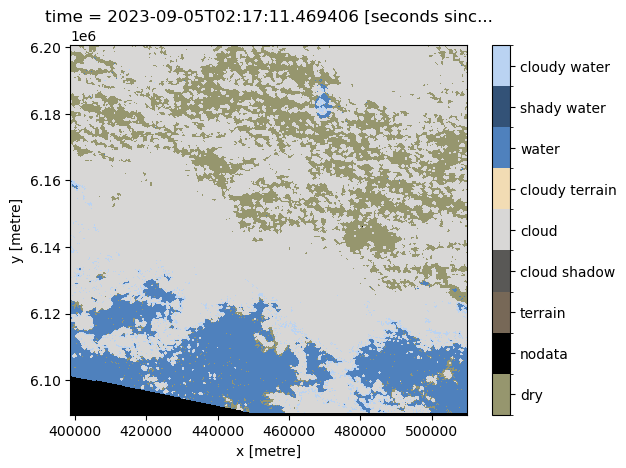

In [31]:
# Apply woffles ard
newwofls = woffles_ard(combined_s2_proper, dsm=None)
# plot woffles ard output
plot_wo(newwofls)

/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../S2_WO_Quality_Testing/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


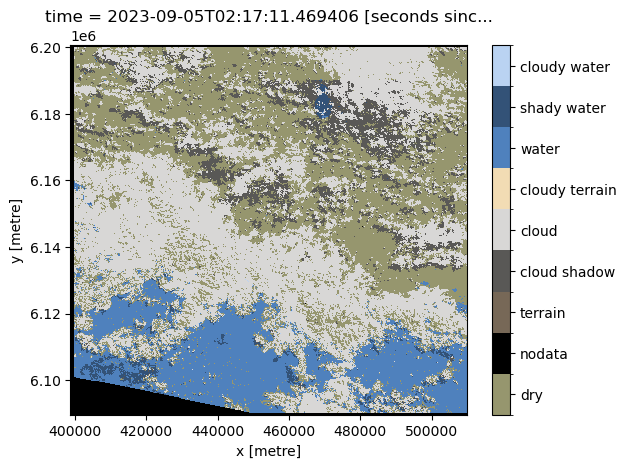

In [32]:
# Apply woffles ard
newwofls = woffles_ard(combined, dsm=None)
# plot woffles ard output
plot_wo(newwofls)

### Quantifying Differences in Outputs
The WOfS algorithm output is a classification with the bit meanings described in the [Water Observations Product Page](https://docs.dea.ga.gov.au/data/product/dea-water-observations-sentinel-2-nrt/). Since classes and combinations of classes have unique values, it is possible to determine which class a pixel changed from by subtracting `new wofl` from `default wofl`. For example, a decimal value of -64 would mean a dry pixel (0) in `default wofl` has been changed to a cloud pixel (64) in `new wofl`.
If the class has not been changed, then the difference between the default and new layer is equal to 0. 

The following matrix provides an example of some changes between classes. Note a pixel can be in more than one class eg. shady water (160 = 32 + 128) and there are many more combinations than the ones shown here. The default wofls decimal values are presented horizontally, and new wofls are vertical. The matrix is populated with the decimal value resulting from the new value subtracted from the default value.


|New \ Default |Class | 0 | 1 | 2 | 4 | 8 | 16 | 32 | 64 | 128 | 160 | 192|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---| --- |
| 0 | Dry or Terrain | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 1 | Null |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 2 | Contiguity Error |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 4 | Solar Incidence > 10 |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 8 | Terrain Shadow |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 16 | High Slope |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 32 | Cloud Shadow |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 64 | Cloud |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 128 | Water |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 160 | Shady Water |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 
| 192 | Cloudy Water |Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | Null | 


/home/jovyan/dev/dea-notebooks/S2_WO_Quality_Testing/../S2_WO_Quality_Testing/wofs-1.6.5/wofs/classifier.py:81: RuntimeWarning: divide by zero encountered in divide
  c = (a - b) / (a + b)


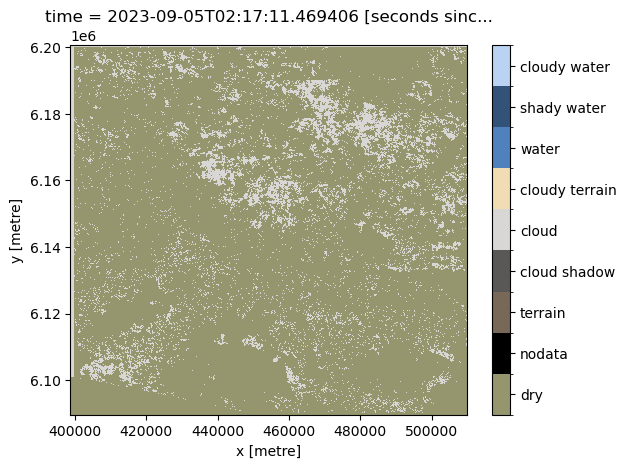

In [33]:
diff = defaultwofls-newwofls
diff0 = diff.where(diff==0, 64)
plot_wo(diff0)

In [34]:
# diff0

### Quantifying Differences Statistically
We can also quantify the differences between the two outputs by summarising the pixel counts for each class. With these values we can calculate the percent change. The amount of change and direction is dependent on the tile and type of artefact issue being addressed.

In [35]:
# do the thing

## Exporting Geotiff
Save your outputs if you want to analyse them with a GIS

In [36]:
# # export the new wofs to save tifs
# # Run `write_cog`
# ds_delayed = write_cog(geo_im=newwofls,
#                        fname='WO_outputs/adelaide_new_wofl.tif',
#                        overwrite=True)

# # Print dask.delayed object
# print(ds_delayed)

In [37]:
# ds_delayed.compute()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)